In [1]:
import numpy as np
import pandas as pd
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten,Dropout
from tensorflow.keras.layers import Conv1D,Conv2D,BatchNormalization,MaxPooling1D,MaxPooling2D,Reshape, Dense, Embedding, LSTM,GRU, Bidirectional, TimeDistributed
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers
from sklearn.model_selection import train_test_split

In [2]:
import tensorflow as tf
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:



In [3]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

## Printing the shapes of the numpy arrays

print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))


Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


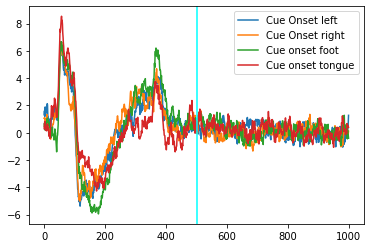

In [4]:
## Adjusting the labels to {0,1,2,3}

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769
## Visualizing the data

ch_data = X_train_valid[:,8,:]


class_0_ind = np.where(y_train_valid == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])


In [5]:
def data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:500]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape)
    return total_X,total_y


X_train_valid_prep,y_train_valid_prep = data_prep(X_train_valid,y_train_valid,2,2,True)


Shape of X after trimming: (2115, 22, 500)
Shape of X after maxpooling: (2115, 22, 250)
Shape of X after averaging+noise and concatenating: (4230, 22, 250)
Shape of X after subsampling and concatenating: (8460, 22, 250)


In [6]:
## Preprocessing the dataset

X_train_valid_prep,y_train_valid_prep = data_prep(X_train_valid,y_train_valid,2,2,True)
X_test_prep,y_test_prep = data_prep(X_test,y_test,2,2,True)

print(X_train_valid_prep.shape)
print(y_train_valid_prep.shape)
print(X_test_prep.shape)
print(y_test_prep.shape)



## Random splitting and reshaping the data

# First generating the training and validation indices using random splitting
ind_valid = np.random.choice(8460, 1500, replace=False)
ind_train = np.array(list(set(range(8460)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(x_train, x_valid) = X_train_valid_prep[ind_train], X_train_valid_prep[ind_valid] 
(y_train, y_valid) = y_train_valid_prep[ind_train], y_train_valid_prep[ind_valid]
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)


# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test_prep, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)


Shape of X after trimming: (2115, 22, 500)
Shape of X after maxpooling: (2115, 22, 250)
Shape of X after averaging+noise and concatenating: (4230, 22, 250)
Shape of X after subsampling and concatenating: (8460, 22, 250)
Shape of X after trimming: (443, 22, 500)
Shape of X after maxpooling: (443, 22, 250)
Shape of X after averaging+noise and concatenating: (886, 22, 250)
Shape of X after subsampling and concatenating: (1772, 22, 250)
(8460, 22, 250)
(8460,)
(1772, 22, 250)
(1772,)
Shape of training set: (6960, 22, 250)
Shape of validation set: (1500, 22, 250)
Shape of training labels: (6960,)
Shape of validation labels: (1500,)
Shape of training labels after categorical conversion: (6960, 4)
Shape of validation labels after categorical conversion: (1500, 4)
Shape of test labels after categorical conversion: (1772, 4)
Shape of training set after adding width info: (6960, 22, 250, 1)
Shape of validation set after adding width info: (1500, 22, 250, 1)
Shape of test set after adding width i

In [7]:
def cnn_model(time_period=1000):   
    time_period = min(time_period, 250)
    
    # Building the CNN model using sequential class
    basic_cnn_model = Sequential()
    
    # Conv. block 1
    basic_cnn_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu', input_shape=(time_period,1,22)))
    basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
    basic_cnn_model.add(BatchNormalization())
    basic_cnn_model.add(Dropout(0.5))

    # Conv. block 2
    basic_cnn_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
    basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
    basic_cnn_model.add(BatchNormalization())
    basic_cnn_model.add(Dropout(0.5))

    # Conv. block 3
    basic_cnn_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
    basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
    basic_cnn_model.add(BatchNormalization())
    basic_cnn_model.add(Dropout(0.5))

    # Conv. block 4
    basic_cnn_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
    basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
    basic_cnn_model.add(BatchNormalization())
    basic_cnn_model.add(Dropout(0.5))

    # Output layer with Softmax activation
    basic_cnn_model.add(Flatten()) # Flattens the input
    basic_cnn_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation
    
    cnn_optimizer = optimizers.Adam(learning_rate)
    
    basic_cnn_model.compile(loss='categorical_crossentropy',
                     optimizer=cnn_optimizer,
                     metrics=['accuracy'])

    # Printing the model summary
    basic_cnn_model.summary()
    
    return basic_cnn_model

In [8]:
# Model parameters
learning_rate = 1.5e-3
epochs = 50

In [9]:
def train_data(time_period=1000):
    # different period of time
    x_train_time = x_train[:,:time_period,:,:]
    y_train_time = y_train
    x_valid_time = x_valid[:,:time_period,:,:]
    y_valid_time = y_valid
    x_test_time = x_test[:,:time_period,:,:]
    y_test_time = y_test
    
    
    model = cnn_model(time_period)

    # Training and validating the model
    cnn_model_results = model.fit(x_train_time,
                 y_train_time,
                 batch_size=200,
                 epochs=epochs,
                 validation_data=(x_valid_time, y_valid_time), verbose=True)
    
    train_score = model.evaluate(x_train_time, y_train_time)
    
    test_score = model.evaluate(x_test_time, y_test_time)

    print('train {:s}: {:.3f}%'.format(model.metrics_names[1], train_score[1]*100))
    print('test {:s}: {:.3f}%'.format(model.metrics_names[1], test_score[1]*100))
    #print(model.summary())
    
    return train_score, test_score

In [10]:
train_scores = []
test_scores = []

for time in range(25, 251, 25):
    print("=================" + str(time) + "===================")
    train_score, test_score = train_data(time_period=time)
    train_scores.append(train_score[1])
    test_scores.append(test_score[1])

=================25===================
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 25, 1, 100)        22100     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 9, 1, 100)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 9, 1, 100)         400       
_________________________________________________________________
dropout (Dropout)            (None, 9, 1, 100)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 1, 100)         100100    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 1, 100)         0         
_________________________________________________________________
batch_normalizati

6960/6960 [==============================] - 3s 453us/sample - loss: 0.8730 - accuracy: 0.6353 - val_loss: 0.7732 - val_accuracy: 0.6880
Epoch 38/50
6960/6960 [==============================] - 3s 394us/sample - loss: 0.8658 - accuracy: 0.6407 - val_loss: 0.7456 - val_accuracy: 0.7140
Epoch 39/50
6960/6960 [==============================] - 6s 818us/sample - loss: 0.9788 - accuracy: 0.5911 - val_loss: 0.8634 - val_accuracy: 0.6353
Epoch 20/50
6960/6960 [==============================] - 6s 809us/sample - loss: 0.9493 - accuracy: 0.6122 - val_loss: 0.9287 - val_accuracy: 0.6073
Epoch 21/50
6960/6960 [==============================] - 5s 717us/sample - loss: 0.9490 - accuracy: 0.6063 - val_loss: 0.7850 - val_accuracy: 0.6820
Epoch 22/50
6960/6960 [==============================] - 6s 849us/sample - loss: 0.9114 - accuracy: 0.6240 - val_loss: 0.7630 - val_accuracy: 0.6873
Epoch 23/50
6960/6960 [==============================] - 5s 730us/sample - loss: 0.8851 - accuracy: 0.6362 - val_loss:

6960/6960 [==============================] - 19s 3ms/sample - loss: 1.9422 - accuracy: 0.2843 - val_loss: 2.3640 - val_accuracy: 0.2793
Epoch 2/50
6960/6960 [==============================] - 8s 1ms/sample - loss: 1.6693 - accuracy: 0.2978 - val_loss: 1.6525 - val_accuracy: 0.2993
Epoch 3/50
6960/6960 [==============================] - 9s 1ms/sample - loss: 1.5351 - accuracy: 0.3083 - val_loss: 1.3555 - val_accuracy: 0.3913
Epoch 4/50
6960/6960 [==============================] - 7s 1ms/sample - loss: 1.4487 - accuracy: 0.3270 - val_loss: 1.3029 - val_accuracy: 0.3813
Epoch 5/50
6960/6960 [==============================] - 9s 1ms/sample - loss: 1.3774 - accuracy: 0.3527 - val_loss: 1.2384 - val_accuracy: 0.4347
Epoch 6/50
6960/6960 [==============================] - 7s 976us/sample - loss: 1.3243 - accuracy: 0.3918 - val_loss: 1.2244 - val_accuracy: 0.4507
Epoch 7/50
6960/6960 [==============================] - 9s 1ms/sample - loss: 1.2775 - accuracy: 0.4218 - val_loss: 1.1793 - val_acc

Train on 6960 samples, validate on 1500 samples
Epoch 1/50
6960/6960 [==============================] - 13s 2ms/sample - loss: 2.0753 - accuracy: 0.2746 - val_loss: 3.3851 - val_accuracy: 0.2793
Epoch 2/50
6960/6960 [==============================] - 9s 1ms/sample - loss: 1.6628 - accuracy: 0.3162 - val_loss: 1.9337 - val_accuracy: 0.3020
Epoch 3/50
6960/6960 [==============================] - 8s 1ms/sample - loss: 1.5048 - accuracy: 0.3379 - val_loss: 1.2674 - val_accuracy: 0.4267
Epoch 4/50
6960/6960 [==============================] - 7s 1ms/sample - loss: 1.3722 - accuracy: 0.3839 - val_loss: 1.1845 - val_accuracy: 0.4587
Epoch 5/50
6960/6960 [==============================] - 9s 1ms/sample - loss: 1.2876 - accuracy: 0.4260 - val_loss: 1.0961 - val_accuracy: 0.5220
Epoch 6/50
6960/6960 [==============================] - 9s 1ms/sample - loss: 1.2231 - accuracy: 0.4520 - val_loss: 1.0564 - val_accuracy: 0.5407
Epoch 7/50
6960/6960 [==============================] - 8s 1ms/sample - los

Train on 6960 samples, validate on 1500 samples
Epoch 1/50
6960/6960 [==============================] - 17s 2ms/sample - loss: 1.9958 - accuracy: 0.2954 - val_loss: 5.9017 - val_accuracy: 0.2740
Epoch 2/50
6960/6960 [==============================] - 10s 1ms/sample - loss: 1.6258 - accuracy: 0.3142 - val_loss: 1.4589 - val_accuracy: 0.3867
Epoch 3/50
6960/6960 [==============================] - 10s 1ms/sample - loss: 1.4331 - accuracy: 0.3700 - val_loss: 1.2182 - val_accuracy: 0.4660
Epoch 4/50
6960/6960 [==============================] - 10s 1ms/sample - loss: 1.2961 - accuracy: 0.4309 - val_loss: 1.1423 - val_accuracy: 0.4880
Epoch 5/50
6960/6960 [==============================] - 9s 1ms/sample - loss: 1.2255 - accuracy: 0.4678 - val_loss: 1.0317 - val_accuracy: 0.5720
Epoch 6/50
6960/6960 [==============================] - 9s 1ms/sample - loss: 1.1476 - accuracy: 0.5072 - val_loss: 1.0352 - val_accuracy: 0.5600
Epoch 7/50
6960/6960 [==============================] - 10s 1ms/sample -

Train on 6960 samples, validate on 1500 samples
Epoch 1/50
6960/6960 [==============================] - 18s 3ms/sample - loss: 2.0133 - accuracy: 0.2889 - val_loss: 2.4351 - val_accuracy: 0.3453
Epoch 2/50
6960/6960 [==============================] - 11s 2ms/sample - loss: 1.6188 - accuracy: 0.3302 - val_loss: 1.6090 - val_accuracy: 0.3827
Epoch 3/50
6960/6960 [==============================] - 12s 2ms/sample - loss: 1.4229 - accuracy: 0.3789 - val_loss: 1.2305 - val_accuracy: 0.4687
Epoch 4/50
6960/6960 [==============================] - 12s 2ms/sample - loss: 1.2988 - accuracy: 0.4269 - val_loss: 1.1124 - val_accuracy: 0.5227
Epoch 5/50
6960/6960 [==============================] - 12s 2ms/sample - loss: 1.1920 - accuracy: 0.4802 - val_loss: 1.0322 - val_accuracy: 0.5473
Epoch 6/50
6960/6960 [==============================] - 11s 2ms/sample - loss: 1.1269 - accuracy: 0.5193 - val_loss: 0.9781 - val_accuracy: 0.5833
Epoch 7/50
6960/6960 [==============================] - 12s 2ms/sample

Train on 6960 samples, validate on 1500 samples
Epoch 1/50
6960/6960 [==============================] - 20s 3ms/sample - loss: 2.0506 - accuracy: 0.2950 - val_loss: 3.1706 - val_accuracy: 0.3353
Epoch 2/50
6960/6960 [==============================] - 13s 2ms/sample - loss: 1.5966 - accuracy: 0.3565 - val_loss: 1.8746 - val_accuracy: 0.3987
Epoch 3/50
6960/6960 [==============================] - 14s 2ms/sample - loss: 1.3928 - accuracy: 0.4144 - val_loss: 1.1523 - val_accuracy: 0.4980
Epoch 4/50
6960/6960 [==============================] - 13s 2ms/sample - loss: 1.2718 - accuracy: 0.4483 - val_loss: 1.1050 - val_accuracy: 0.5353
Epoch 5/50
6960/6960 [==============================] - 15s 2ms/sample - loss: 1.1397 - accuracy: 0.5134 - val_loss: 1.0140 - val_accuracy: 0.5700
Epoch 6/50
6960/6960 [==============================] - 13s 2ms/sample - loss: 1.0613 - accuracy: 0.5522 - val_loss: 0.9750 - val_accuracy: 0.5640
Epoch 7/50
6960/6960 [==============================] - 14s 2ms/sample

Train on 6960 samples, validate on 1500 samples
Epoch 1/50
6960/6960 [==============================] - 23s 3ms/sample - loss: 2.0226 - accuracy: 0.3152 - val_loss: 3.6738 - val_accuracy: 0.2773
Epoch 2/50
6960/6960 [==============================] - 15s 2ms/sample - loss: 1.6070 - accuracy: 0.3494 - val_loss: 1.9351 - val_accuracy: 0.3747
Epoch 3/50
6960/6960 [==============================] - 16s 2ms/sample - loss: 1.3709 - accuracy: 0.4162 - val_loss: 1.2376 - val_accuracy: 0.5173
Epoch 4/50
6960/6960 [==============================] - 15s 2ms/sample - loss: 1.2321 - accuracy: 0.4770 - val_loss: 1.0553 - val_accuracy: 0.5587
Epoch 5/50
6960/6960 [==============================] - 16s 2ms/sample - loss: 1.1581 - accuracy: 0.5096 - val_loss: 1.0305 - val_accuracy: 0.5533
Epoch 6/50
6960/6960 [==============================] - 15s 2ms/sample - loss: 1.0784 - accuracy: 0.5455 - val_loss: 0.9438 - val_accuracy: 0.5967
Epoch 7/50
6960/6960 [==============================] - 16s 2ms/sample

Train on 6960 samples, validate on 1500 samples
Epoch 1/50
6960/6960 [==============================] - 23s 3ms/sample - loss: 2.0096 - accuracy: 0.3112 - val_loss: 3.9235 - val_accuracy: 0.3153
Epoch 2/50
6960/6960 [==============================] - 17s 2ms/sample - loss: 1.5486 - accuracy: 0.3816 - val_loss: 2.0927 - val_accuracy: 0.4000
Epoch 3/50
6960/6960 [==============================] - 16s 2ms/sample - loss: 1.3244 - accuracy: 0.4443 - val_loss: 1.4366 - val_accuracy: 0.4780
Epoch 4/50
6960/6960 [==============================] - 17s 2ms/sample - loss: 1.2038 - accuracy: 0.4951 - val_loss: 1.0895 - val_accuracy: 0.5307
Epoch 5/50
6960/6960 [==============================] - 17s 2ms/sample - loss: 1.1196 - accuracy: 0.5318 - val_loss: 1.0016 - val_accuracy: 0.5647
Epoch 6/50
6960/6960 [==============================] - 17s 2ms/sample - loss: 1.0413 - accuracy: 0.5705 - val_loss: 0.8947 - val_accuracy: 0.6400
Epoch 7/50
6960/6960 [==============================] - 17s 3ms/sample

Train on 6960 samples, validate on 1500 samples
Epoch 1/50
6960/6960 [==============================] - 24s 3ms/sample - loss: 1.9531 - accuracy: 0.3336 - val_loss: 2.6227 - val_accuracy: 0.3620
Epoch 2/50
6960/6960 [==============================] - 19s 3ms/sample - loss: 1.5830 - accuracy: 0.3639 - val_loss: 1.8801 - val_accuracy: 0.3953
Epoch 3/50
6960/6960 [==============================] - 18s 3ms/sample - loss: 1.3404 - accuracy: 0.4292 - val_loss: 1.2260 - val_accuracy: 0.5120
Epoch 4/50
6960/6960 [==============================] - 18s 3ms/sample - loss: 1.2314 - accuracy: 0.4747 - val_loss: 1.0448 - val_accuracy: 0.5647
Epoch 5/50
6960/6960 [==============================] - 19s 3ms/sample - loss: 1.1167 - accuracy: 0.5302 - val_loss: 0.9851 - val_accuracy: 0.5747
Epoch 6/50
6960/6960 [==============================] - 21s 3ms/sample - loss: 1.0527 - accuracy: 0.5572 - val_loss: 0.9828 - val_accuracy: 0.5853
Epoch 7/50
6960/6960 [==============================] - 20s 3ms/sample

Train accuracies: 
[0.91695404, 0.9801724, 0.98821837, 0.9961207, 0.99899423, 0.9992816, 0.99755746, 0.9994253, 0.9974138, 1.0]
Test accuracies: 
[0.3860045, 0.53724605, 0.5846501, 0.65688485, 0.7003386, 0.70259595, 0.68453723, 0.69808125, 0.68340856, 0.70598197]


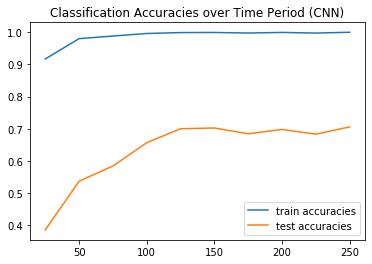

In [11]:
print("Train accuracies: ")
print(train_scores)
print("Test accuracies: ")
print(test_scores)

# plot
plt.plot(range(25, 251, 25), train_scores, label='train accuracies')
plt.plot(range(25, 251, 25), test_scores, label='test accuracies')
plt.legend()
plt.title("Classification Accuracies over Time Period (CNN)")
plt.show()

In [12]:
def hybrid_model(time_period=250):   
    
    # Building the CNN model using sequential class
    hybrid_cnn_lstm_model = Sequential()

    # Conv. block 1
    hybrid_cnn_lstm_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu', input_shape=(time_period,1,22)))
    hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
    hybrid_cnn_lstm_model.add(BatchNormalization())
    hybrid_cnn_lstm_model.add(Dropout(0.5))

    # Conv. block 2
    hybrid_cnn_lstm_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
    hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
    hybrid_cnn_lstm_model.add(BatchNormalization())
    hybrid_cnn_lstm_model.add(Dropout(0.5))

    # Conv. block 3
    hybrid_cnn_lstm_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
    hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
    hybrid_cnn_lstm_model.add(BatchNormalization())
    hybrid_cnn_lstm_model.add(Dropout(0.5))

    # Conv. block 4
    #hybrid_cnn_lstm_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
    #hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
    #hybrid_cnn_lstm_model.add(BatchNormalization())
    #hybrid_cnn_lstm_model.add(Dropout(0.5))

    # FC+LSTM layers
    hybrid_cnn_lstm_model.add(Flatten()) # Adding a flattening operation to the output of CNN block
    hybrid_cnn_lstm_model.add(Dense((100))) # FC layer with 100 units
    hybrid_cnn_lstm_model.add(Reshape((100,1))) # Reshape my output of FC layer so that it's compatible
    hybrid_cnn_lstm_model.add(LSTM(100, dropout=0.5, recurrent_dropout=0.1, input_shape=(100,1), return_sequences=True))

    hybrid_cnn_lstm_model.add(LSTM(70, dropout=0.5, recurrent_dropout=0.1, return_sequences=False))
    # Output layer with Softmax activation 
    hybrid_cnn_lstm_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


    hybrid_cnn_lstm_model.compile(loss='categorical_crossentropy', optimizer=hybrid_cnn_lstm_optimizer, metrics=['accuracy'])

    # Printing the model summary
    hybrid_cnn_lstm_model.summary()
    
    return hybrid_cnn_lstm_model

In [13]:
# Model parameters
learning_rate = 2e-3
epochs = 50
hybrid_cnn_lstm_optimizer = optimizers.Adam(lr=learning_rate)

In [14]:
def hybrid_train_data(time_period=250):
    # different period of time
    x_train_time = x_train[:,:time_period,:,:]
    y_train_time = y_train
    x_valid_time = x_valid[:,:time_period,:,:]
    y_valid_time = y_valid
    x_test_time = x_test[:,:time_period,:,:]
    y_test_time = y_test
    
    
    model = hybrid_model(time_period)

    # Training and validating the model
    cnn_model_results = model.fit(x_train_time,
                 y_train_time,
                 batch_size=200,
                 epochs=epochs,
                 validation_data=(x_valid_time, y_valid_time), verbose=True)
    
    train_score = model.evaluate(x_train_time, y_train_time)
    
    test_score = model.evaluate(x_test_time, y_test_time)

    print('train {:s}: {:.3f}%'.format(model.metrics_names[1], train_score[1]*100))
    print('test {:s}: {:.3f}%'.format(model.metrics_names[1], test_score[1]*100))
    #print(model.summary())
    
    return train_score, test_score

In [15]:
train_scores = []
test_scores = []

for time in range(25, 251, 25):
    print("=================" + str(time) + "===================")
    train_score, test_score = hybrid_train_data(time_period=time)
    train_scores.append(train_score[1])
    test_scores.append(test_score[1])

=================25===================
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 25, 1, 100)        22100     
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 9, 1, 100)         0         
_________________________________________________________________
batch_normalization_40 (Batc (None, 9, 1, 100)         400       
_________________________________________________________________
dropout_40 (Dropout)         (None, 9, 1, 100)         0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 9, 1, 100)         100100    
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 3, 1, 100)         0         
_________________________________________________________________
batch_normaliz

6960/6960 [==============================] - 30s 4ms/sample - loss: 0.8782 - accuracy: 0.6289 - val_loss: 0.7789 - val_accuracy: 0.6993
Epoch 38/50
6960/6960 [==============================] - 27s 4ms/sample - loss: 0.8605 - accuracy: 0.6385 - val_loss: 0.7784 - val_accuracy: 0.7213
Epoch 39/50
6960/6960 [==============================] - 30s 4ms/sample - loss: 0.8481 - accuracy: 0.6435 - val_loss: 0.7656 - val_accuracy: 0.7093
Epoch 40/50
6960/6960 [==============================] - 28s 4ms/sample - loss: 0.8497 - accuracy: 0.6471 - val_loss: 0.7494 - val_accuracy: 0.7153
Epoch 41/50
6960/6960 [==============================] - 27s 4ms/sample - loss: 0.8546 - accuracy: 0.6405 - val_loss: 0.7690 - val_accuracy: 0.7027
Epoch 42/50
6960/6960 [==============================] - 28s 4ms/sample - loss: 0.8416 - accuracy: 0.6493 - val_loss: 0.7839 - val_accuracy: 0.7240
Epoch 43/50
6960/6960 [==============================] - 30s 4ms/sample - loss: 0.8352 - accuracy: 0.6480 - val_loss: 0.7347

Epoch 22/50
6960/6960 [==============================] - 42s 6ms/sample - loss: 0.8085 - accuracy: 0.6680 - val_loss: 0.6599 - val_accuracy: 0.7633
Epoch 23/50
6960/6960 [==============================] - 41s 6ms/sample - loss: 0.8087 - accuracy: 0.6693 - val_loss: 0.6327 - val_accuracy: 0.7867
Epoch 24/50
6960/6960 [==============================] - 41s 6ms/sample - loss: 0.7850 - accuracy: 0.6770 - val_loss: 0.6449 - val_accuracy: 0.7640
Epoch 25/50
6960/6960 [==============================] - 41s 6ms/sample - loss: 0.7717 - accuracy: 0.6869 - val_loss: 0.6012 - val_accuracy: 0.7973
Epoch 26/50
6960/6960 [==============================] - 42s 6ms/sample - loss: 0.7450 - accuracy: 0.7039 - val_loss: 0.5853 - val_accuracy: 0.8060
Epoch 27/50
6960/6960 [==============================] - 41s 6ms/sample - loss: 0.7285 - accuracy: 0.7046 - val_loss: 0.5723 - val_accuracy: 0.8113
Epoch 28/50
6960/6960 [==============================] - 40s 6ms/sample - loss: 0.7201 - accuracy: 0.7096 - val_

Epoch 7/50
6960/6960 [==============================] - 43s 6ms/sample - loss: 1.2007 - accuracy: 0.4572 - val_loss: 1.1785 - val_accuracy: 0.5020
Epoch 8/50
6960/6960 [==============================] - 37s 5ms/sample - loss: 1.1679 - accuracy: 0.4716 - val_loss: 1.1011 - val_accuracy: 0.5233
Epoch 9/50
6960/6960 [==============================] - 39s 6ms/sample - loss: 1.1521 - accuracy: 0.4838 - val_loss: 1.0226 - val_accuracy: 0.5580
Epoch 10/50
6960/6960 [==============================] - 42s 6ms/sample - loss: 1.1204 - accuracy: 0.4914 - val_loss: 1.0084 - val_accuracy: 0.5640
Epoch 11/50
6960/6960 [==============================] - 40s 6ms/sample - loss: 1.0871 - accuracy: 0.5188 - val_loss: 0.9761 - val_accuracy: 0.5600
Epoch 12/50
6960/6960 [==============================] - 41s 6ms/sample - loss: 1.0779 - accuracy: 0.5203 - val_loss: 0.9450 - val_accuracy: 0.6040
Epoch 13/50
6960/6960 [==============================] - 40s 6ms/sample - loss: 1.0505 - accuracy: 0.5349 - val_los

6960/6960 [==============================] - 60s 9ms/sample - loss: 1.3953 - accuracy: 0.2642 - val_loss: 1.3732 - val_accuracy: 0.2887
Epoch 2/50
6960/6960 [==============================] - 43s 6ms/sample - loss: 1.3647 - accuracy: 0.3193 - val_loss: 1.4323 - val_accuracy: 0.2960
Epoch 3/50
6960/6960 [==============================] - 46s 7ms/sample - loss: 1.3184 - accuracy: 0.3743 - val_loss: 1.4028 - val_accuracy: 0.2947
Epoch 4/50
6960/6960 [==============================] - 45s 7ms/sample - loss: 1.2631 - accuracy: 0.4205 - val_loss: 1.3774 - val_accuracy: 0.3513
Epoch 5/50
6960/6960 [==============================] - 46s 7ms/sample - loss: 1.2227 - accuracy: 0.4420 - val_loss: 1.2043 - val_accuracy: 0.4520
Epoch 6/50
6960/6960 [==============================] - 45s 6ms/sample - loss: 1.1730 - accuracy: 0.4707 - val_loss: 1.0780 - val_accuracy: 0.5200
Epoch 7/50
6960/6960 [==============================] - 46s 7ms/sample - loss: 1.1448 - accuracy: 0.4849 - val_loss: 1.0403 - val

Train on 6960 samples, validate on 1500 samples
Epoch 1/50
6960/6960 [==============================] - 67s 10ms/sample - loss: 1.3882 - accuracy: 0.2800 - val_loss: 1.3644 - val_accuracy: 0.3133
Epoch 2/50
6960/6960 [==============================] - 53s 8ms/sample - loss: 1.3426 - accuracy: 0.3480 - val_loss: 1.3343 - val_accuracy: 0.3593
Epoch 3/50
6960/6960 [==============================] - 53s 8ms/sample - loss: 1.2668 - accuracy: 0.4161 - val_loss: 1.2353 - val_accuracy: 0.4307
Epoch 4/50
6960/6960 [==============================] - 54s 8ms/sample - loss: 1.2037 - accuracy: 0.4632 - val_loss: 1.1614 - val_accuracy: 0.4867
Epoch 5/50
6960/6960 [==============================] - 54s 8ms/sample - loss: 1.1763 - accuracy: 0.4690 - val_loss: 1.1780 - val_accuracy: 0.4893
Epoch 6/50
6960/6960 [==============================] - 52s 7ms/sample - loss: 1.1345 - accuracy: 0.4925 - val_loss: 1.0454 - val_accuracy: 0.5473
Epoch 7/50
6960/6960 [==============================] - 52s 8ms/sampl

Train on 6960 samples, validate on 1500 samples
Epoch 1/50
6960/6960 [==============================] - 65s 9ms/sample - loss: 1.3959 - accuracy: 0.2635 - val_loss: 1.4509 - val_accuracy: 0.2467
Epoch 2/50
6960/6960 [==============================] - 54s 8ms/sample - loss: 1.3543 - accuracy: 0.3207 - val_loss: 1.3513 - val_accuracy: 0.3120
Epoch 3/50
6960/6960 [==============================] - 51s 7ms/sample - loss: 1.2986 - accuracy: 0.3852 - val_loss: 1.3249 - val_accuracy: 0.3693
Epoch 4/50
6960/6960 [==============================] - 56s 8ms/sample - loss: 1.2525 - accuracy: 0.4185 - val_loss: 1.1676 - val_accuracy: 0.4807
Epoch 5/50
6960/6960 [==============================] - 55s 8ms/sample - loss: 1.1654 - accuracy: 0.4700 - val_loss: 1.0997 - val_accuracy: 0.5167
Epoch 6/50
6960/6960 [==============================] - 54s 8ms/sample - loss: 1.1164 - accuracy: 0.4989 - val_loss: 1.0298 - val_accuracy: 0.5460
Epoch 7/50
6960/6960 [==============================] - 54s 8ms/sample

Train on 6960 samples, validate on 1500 samples
Epoch 1/50
6960/6960 [==============================] - 73s 10ms/sample - loss: 1.3849 - accuracy: 0.2884 - val_loss: 1.4196 - val_accuracy: 0.2520
Epoch 2/50
6960/6960 [==============================] - 59s 8ms/sample - loss: 1.3264 - accuracy: 0.3496 - val_loss: 1.3484 - val_accuracy: 0.3327
Epoch 3/50
6960/6960 [==============================] - 58s 8ms/sample - loss: 1.2607 - accuracy: 0.4014 - val_loss: 1.2893 - val_accuracy: 0.3920
Epoch 4/50
6960/6960 [==============================] - 59s 9ms/sample - loss: 1.1968 - accuracy: 0.4532 - val_loss: 1.1695 - val_accuracy: 0.4760
Epoch 5/50
6960/6960 [==============================] - 56s 8ms/sample - loss: 1.1201 - accuracy: 0.4984 - val_loss: 1.0782 - val_accuracy: 0.5187
Epoch 6/50
6960/6960 [==============================] - 58s 8ms/sample - loss: 1.0884 - accuracy: 0.5197 - val_loss: 1.0704 - val_accuracy: 0.5213
Epoch 7/50
6960/6960 [==============================] - 58s 8ms/sampl

Train on 6960 samples, validate on 1500 samples
Epoch 1/50
6960/6960 [==============================] - 82s 12ms/sample - loss: 1.3909 - accuracy: 0.2695 - val_loss: 1.4422 - val_accuracy: 0.2447
Epoch 2/50
6960/6960 [==============================] - 61s 9ms/sample - loss: 1.3495 - accuracy: 0.3431 - val_loss: 1.4872 - val_accuracy: 0.3153
Epoch 3/50
6960/6960 [==============================] - 58s 8ms/sample - loss: 1.2787 - accuracy: 0.4014 - val_loss: 1.3377 - val_accuracy: 0.3800
Epoch 4/50
6960/6960 [==============================] - 58s 8ms/sample - loss: 1.2244 - accuracy: 0.4358 - val_loss: 1.2872 - val_accuracy: 0.4313
Epoch 5/50
6960/6960 [==============================] - 58s 8ms/sample - loss: 1.1843 - accuracy: 0.4632 - val_loss: 1.1612 - val_accuracy: 0.4593
Epoch 6/50
6960/6960 [==============================] - 58s 8ms/sample - loss: 1.1189 - accuracy: 0.5010 - val_loss: 1.1320 - val_accuracy: 0.4807
Epoch 7/50
6960/6960 [==============================] - 56s 8ms/sampl

Train on 6960 samples, validate on 1500 samples
Epoch 1/50
6960/6960 [==============================] - 157s 23ms/sample - loss: 1.3796 - accuracy: 0.2898 - val_loss: 1.7431 - val_accuracy: 0.2700
Epoch 2/50
6960/6960 [==============================] - 92s 13ms/sample - loss: 1.2950 - accuracy: 0.3848 - val_loss: 1.3078 - val_accuracy: 0.3973
Epoch 3/50
6960/6960 [==============================] - 93s 13ms/sample - loss: 1.2009 - accuracy: 0.4487 - val_loss: 1.2906 - val_accuracy: 0.4273
Epoch 4/50
6960/6960 [==============================] - 96s 14ms/sample - loss: 1.1325 - accuracy: 0.4882 - val_loss: 1.1056 - val_accuracy: 0.5073
Epoch 5/50
6960/6960 [==============================] - 85s 12ms/sample - loss: 1.0874 - accuracy: 0.5080 - val_loss: 1.0310 - val_accuracy: 0.5487
Epoch 6/50
6960/6960 [==============================] - 84s 12ms/sample - loss: 1.0232 - accuracy: 0.5338 - val_loss: 0.9945 - val_accuracy: 0.5573
Epoch 7/50
6960/6960 [==============================] - 90s 13m

Train on 6960 samples, validate on 1500 samples
Epoch 1/50
6960/6960 [==============================] - 126s 18ms/sample - loss: 1.3905 - accuracy: 0.2743 - val_loss: 1.4658 - val_accuracy: 0.2620
Epoch 2/50
6960/6960 [==============================] - 79s 11ms/sample - loss: 1.3167 - accuracy: 0.3595 - val_loss: 1.4051 - val_accuracy: 0.3460
Epoch 3/50
6960/6960 [==============================] - 81s 12ms/sample - loss: 1.2383 - accuracy: 0.4233 - val_loss: 1.3937 - val_accuracy: 0.4047
Epoch 4/50
6960/6960 [==============================] - 82s 12ms/sample - loss: 1.1501 - accuracy: 0.4739 - val_loss: 1.1543 - val_accuracy: 0.4833
Epoch 5/50
6960/6960 [==============================] - 85s 12ms/sample - loss: 1.0753 - accuracy: 0.5118 - val_loss: 1.0323 - val_accuracy: 0.5480
Epoch 6/50
6960/6960 [==============================] - 82s 12ms/sample - loss: 1.0330 - accuracy: 0.5333 - val_loss: 0.9178 - val_accuracy: 0.5987
Epoch 7/50
6960/6960 [==============================] - 82s 12m

Train accuracies: 
[0.9028736, 0.97988504, 0.9863506, 0.979023, 0.99324715, 0.99755746, 0.9982759, 0.9968391, 0.99640805, 0.99698275]
Test accuracies: 
[0.38487583, 0.501693, 0.5468397, 0.5790068, 0.60158014, 0.6574492, 0.6518059, 0.6625282, 0.64672685, 0.65857786]


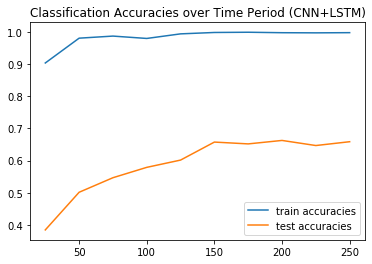

In [16]:
print("Train accuracies: ")
print(train_scores)
print("Test accuracies: ")
print(test_scores)

# plot
plt.plot(range(25, 251, 25), train_scores, label='train accuracies')
plt.plot(range(25, 251, 25), test_scores, label='test accuracies')
plt.legend()
plt.title("Classification Accuracies over Time Period (CNN+LSTM)")
plt.show()